<div style="background-color: lightpink; padding: 10px;">

# This notebook will discuss a mock small-loan eligibility problem: 

## I'm going to apply classification machine learning models to determine whether accounts will qualify for small loans. Based only on their bank transaction data. The training labels are based on previous loans being paid back on time or not.

Steps outline:
1. Process/transform/clean and visualize raw data. 

2. Feature engineering: Select Features based on objective: Predict loan eligibility based on bank transaction data. Define 'loan_eligibility' based on rules.

3. Exploratory Data Analysis / Data Visualization: Histograms, box plots, and scatter plots to understand feature distributions and relationships. Correlation Analysis: Identify correlations between features and target variable. (Descriptive Statistics: Summary statistics of the features).

4. Select ML model. (e.g., Logistic Regression, Random Forests, Gradient Boosting, SVM, Neural Networks). Prepare data by splitting into training and testing. (80% train, 20% test). Hyperparameter Tuning: Use techniques like Grid Search or Random Search for hyperparameter optimization.

5. Model Evaluation and interpretation: Accuracy, Precision, Recall, F1 Score, (maybe: ROC-AUC), Model Comparison
</div>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

# <font color='purple'>Step 1. Clean and view data</font> 

In [2]:
#Load dataframes
transactions = pd.read_parquet("data_science_take_home_transactions.parquet", engine='pyarrow')
advances = pd.read_parquet("data_science_take_home_advances.parquet", engine='pyarrow')
#transactions.head()
advances.head()

,account_id,state,amount,due_date,repaid_on
0,0adv34tf69c76,ADVANCE_STATE_REPAYMENT,5000.000000000,2023-01-09,None
1,ahmdvxy8kq3gj,ADVANCE_STATE_REPAYMENT,5000.000000000,2023-01-09,None
2,1jq4t1y123xd4,ADVANCE_STATE_REPAYMENT,5000.000000000,2023-01-08,None
3,k9tw3fj0c6fp0,ADVANCE_STATE_REPAYMENT,5000.000000000,2023-01-23,None
4,bahm3606b8rse,ADVANCE_STATE_REPAYMENT,5000.000000000,2023-01-08,None


<div style="background-color: lightgreen; padding: 10px;">

I will be selecting my features from the transactional data and my target variable from the advances data. I.e paid back or paid on time=qulify for loan

    
</div>

In [3]:
selected_columns_trans = transactions.loc[:, ['account_id', 'f0_', 'date']] #remove other columns
selected_columns_adv = advances.loc[:, ['account_id', 'amount', 'due_date', 'repaid_on']] #remove other columns
cleaned_data_trans = selected_columns_trans.copy()
cleaned_data_adv = selected_columns_adv.copy()

cleaned_data_trans['date'] = pd.to_datetime(cleaned_data_trans['date']) #Convert the 'date' column to datetime
cleaned_data_adv['due_date'] = pd.to_datetime(cleaned_data_adv['due_date']) 
cleaned_data_adv['repaid_on'] = pd.to_datetime(cleaned_data_adv['repaid_on'])

# ad loan paid, and paid on time columns. 1=yes 0=no
cleaned_data_adv['paid_back'] = np.where(cleaned_data_adv['repaid_on'].isna() | (cleaned_data_adv['repaid_on'] == 0), 0, 1)
cleaned_data_adv['paid_on_time'] = (cleaned_data_adv['repaid_on'] <= cleaned_data_adv['due_date']).astype(int)

count_paid_back = (cleaned_data_adv['paid_back'] == 1).sum()
count_paid_on_time = (cleaned_data_adv['paid_on_time'] == 1).sum()

print(f"Total number of unique accounts: {cleaned_data_adv['account_id'].nunique()}")
print(f"Number of accounts who paid back: {count_paid_back}, {100*((count_paid_back) / cleaned_data_adv['account_id'].nunique()).round(2)} %") 
print(f"Number of accounts who paid on time: {count_paid_on_time}, {100*((count_paid_on_time) / cleaned_data_adv['account_id'].nunique()).round(2)} %")
print(f"Number of accounts who paid back but not on time: {count_paid_back - count_paid_on_time}")

cleaned_data_adv

Total number of unique accounts: 1904
Number of accounts who paid back: 1591, 84.0 %
Number of accounts who paid on time: 971, 51.0 %
Number of accounts who paid back but not on time: 620


,account_id,amount,due_date,repaid_on,paid_back,paid_on_time
0,0adv34tf69c76,5000.000000000,2023-01-09,NaT,0,0
1,ahmdvxy8kq3gj,5000.000000000,2023-01-09,NaT,0,0
2,1jq4t1y123xd4,5000.000000000,2023-01-08,NaT,0,0
3,k9tw3fj0c6fp0,5000.000000000,2023-01-23,NaT,0,0
4,bahm3606b8rse,5000.000000000,2023-01-08,NaT,0,0
...,...,...,...,...,...,...
1899,5jsy2xsqky042,5000.000000000,2023-02-24,2023-03-06,1,0
1900,g1k332y0mj9ww,5000.000000000,2023-02-24,2023-03-10,1,0
1901,12ghpqc0gs4vr,5000.000000000,2023-02-24,2023-03-12,1,0
1902,gjtbp7r05qdtc,5000.000000000,2023-02-24,2023-03-12,1,0


# <font color='purple'>Step 2. Select Features</font>


Features on transactional dataframe:

- 1. Age of account: the more data we have, the more accurate machine learning models.

- 2. Average monthly balance Sum total tranasactions each month, then average over the total months.

- 3. Average weekly balance: Sum total tranasactions each month, then average over the total weeks.

- 4. Number of months where deposits exceed witdrawls i.e net positive (normalize by dividing by number of months account has been active.)

- 5. Average amount by which withdrawals exceed deposits: for months of net positive transaction: average by how much. (normalize by dividing by number of months).

- 6. Number of weeks where deposits exceed witdrawls i.e net positive (normalize by dividing by number of weeks account has been active.)

- 7. Average amount by which withdrawals exceed deposits: for weeks of net positive transaction: average by how much.



<div style="background-color: lightgreen; padding: 10px;">
The reason we do month and week here is to capture behaviors over different times-ranges since behaviors might vary based on time of month etc. We could possibly include daily and bi-weekly behaviors but I would have to think more about this case. Could possibly add a time-series lag feature to improve accuracy further.

***A major issue is transactions between accounts--not seens as income/spending...hence, if we filter these out our model will improve
    
    
*** What else would be good features? Need more external data. An obvious one would be credit score/history. Employment status. Age. Marital status.
    
*** Lets add transaction frequency? i.e number of transactions per month and number of large transactions per month etc.
    
    
    
</div>


In [4]:
# FEATURE 1. Calculate the age of the account for each account_id
account_age = cleaned_data_trans.groupby('account_id')['date'].agg(['min', 'max'])
account_age['account_age_days'] = (account_age['max'] - account_age['min']).dt.days
#account_age['account_age_months'] = np.ceil((account_age['max'] - account_age['min']) / pd.Timedelta(days=31)).astype(int)
#account_age['account_age_weeks'] = (account_age['account_age_days'] / 7).astype(int)

# FEATURE 2. Calculate Montly Average f0_
average_f0_monthly = cleaned_data_trans.groupby(['account_id', cleaned_data_trans['date'].dt.to_period('M')])['f0_'].mean().reset_index()
average_f0_monthly.rename(columns={'f0_': 'avg_f0_monthly'}, inplace=True)
average_f0_all_months = average_f0_monthly.groupby('account_id')['avg_f0_monthly'].mean().reset_index()
#average_f0_all_months

# FEATURE 3. Calculate Weekly Average f0_
average_f0_weekly = cleaned_data_trans.groupby(['account_id', cleaned_data_trans['date'].dt.to_period('W')])['f0_'].mean().reset_index()
average_f0_weekly.rename(columns={'f0_': 'avg_f0_weekly'}, inplace=True)
average_f0_all_weeks = average_f0_weekly.groupby('account_id')['avg_f0_weekly'].mean().reset_index()
#average_f0_all_weeks

# FEATURE 4. Number of months with net f0_ >0 / total number of months
net_positive_months = cleaned_data_trans[cleaned_data_trans['f0_'] >= 0].groupby('account_id')['date'].apply(lambda x: x.dt.to_period('M').nunique()).reset_index()
net_positive_months.rename(columns={'date': 'num_net_positive_months'}, inplace=True)
total_active_months = cleaned_data_trans.groupby('account_id')['date'].apply(lambda x: x.dt.to_period('M').nunique()).reset_index()
total_active_months.rename(columns={'date': 'total_months_active'}, inplace=True)
net_positive_months_avg = pd.merge(net_positive_months, total_active_months, on='account_id', how='left')
net_positive_months_avg['norm_num_net_positive_months'] = net_positive_months_avg['num_net_positive_months'] / net_positive_months_avg['total_months_active']
net_positive_months_avg = net_positive_months_avg[['account_id', 'norm_num_net_positive_months']]
#net_positive_months_avg

# FEATURE 5. Average amount by which deposits exceed withdrawls, by month
net_positive_transactions = cleaned_data_trans[cleaned_data_trans['f0_'] >= 0].copy()
net_positive_transactions['month'] = net_positive_transactions['date'].dt.to_period('M') # Extract month and year from 'date'
avg_net_positive = net_positive_transactions.groupby(['account_id', 'month'])['f0_'].mean().reset_index()
avg_net_positive.rename(columns={'f0_': 'avg_monthly_net_positive'}, inplace=True)
avg_net_positive_all_months = avg_net_positive.groupby('account_id')['avg_monthly_net_positive'].mean().reset_index()
#avg_net_positive_all_months

# FEATURE 6. Number of weeks with net f0_ >0 / total number of weeks.
net_positive_weeks = cleaned_data_trans[cleaned_data_trans['f0_'] >= 0].groupby('account_id')['date'].apply(lambda x: x.dt.to_period('W').nunique()).reset_index()
net_positive_weeks.rename(columns={'date': 'num_net_positive_weeks'}, inplace=True)
total_active_weeks = cleaned_data_trans.groupby('account_id')['date'].apply(lambda x: x.dt.to_period('W').nunique()).reset_index()
total_active_weeks.rename(columns={'date': 'total_weeks_active'}, inplace=True)
net_positive_weeks_avg = pd.merge(net_positive_weeks, total_active_weeks, on='account_id', how='left')
net_positive_weeks_avg['norm_num_net_positive_weeks'] = net_positive_weeks_avg['num_net_positive_weeks'] / net_positive_weeks_avg['total_weeks_active']
net_positive_weeks_avg = net_positive_weeks_avg[['account_id', 'norm_num_net_positive_weeks']]
#net_positive_weeks_avg

# FEATURE 7. Average amount by which withdrawals exceed deposits, by week
# Filter transactions with net positive (f0_ > 0)
net_positive_transactions = cleaned_data_trans[cleaned_data_trans['f0_'] >= 0].copy()
net_positive_transactions['week'] = net_positive_transactions['date'].dt.to_period('W')# Extract week and year from 'date'
avg_net_positive = net_positive_transactions.groupby(['account_id', 'week'])['f0_'].mean().reset_index()
avg_net_positive.rename(columns={'f0_': 'avg_weekly_net_positive'}, inplace=True)
avg_net_positive_all_weeks = avg_net_positive.groupby('account_id')['avg_weekly_net_positive'].mean().reset_index()# Calculate average across all weeks with net positive transactions for each account
#avg_net_positive_all_weeks

# <font color='purple'>Step 3. EDA</font>

In [5]:
features_for_ML = cleaned_data_adv[['account_id']].copy()
features_for_ML = pd.merge(account_age['account_age_days'], average_f0_all_months, on='account_id', how='left')
features_for_ML = pd.merge(features_for_ML, average_f0_all_weeks, on='account_id', how='left')
features_for_ML = pd.merge(features_for_ML, net_positive_months_avg, on='account_id', how='left')
features_for_ML = pd.merge(features_for_ML, avg_net_positive_all_months, on='account_id', how='left')
features_for_ML = pd.merge(features_for_ML, net_positive_weeks_avg, on='account_id', how='left')
features_for_ML = pd.merge(features_for_ML, avg_net_positive_all_weeks, on='account_id', how='left')

feature_range = features_for_ML.describe().loc[['min', 'max']]

# Display the range of features
print("Range of Features:")
print(feature_range)
features_for_ML.head(5)

Range of Features:
     account_age_days  avg_f0_monthly  avg_f0_weekly  \
min               0.0     -101.044365     -55.925577   
max             755.0     3934.963995    1115.858813   

     norm_num_net_positive_months  avg_monthly_net_positive  \
min                      0.428571                   0.06000   
max                      1.000000                6869.76168   

     norm_num_net_positive_weeks  avg_weekly_net_positive  
min                          0.3                 0.060000  
max                          1.0              3061.742643  


,account_id,account_age_days,avg_f0_monthly,avg_f0_weekly,norm_num_net_positive_months,avg_monthly_net_positive,norm_num_net_positive_weeks,avg_weekly_net_positive
0,00j9a14cpe87j,425,3.129400,1.452657,1.000000,313.269044,1.000000,329.279162
1,00q86t07z45h6,51,7.060446,17.130361,1.000000,532.418571,0.875000,482.041905
2,00wndxsnkr29c,424,-0.993212,-4.871179,0.933333,1089.617135,0.693548,1087.272667
3,00xk7rt4tjvem,413,3.531136,14.567898,1.000000,266.802753,0.927273,345.029376
4,01f4d9se2cztj,142,3.740626,-2.663537,1.000000,158.952031,0.923077,232.656403


In [8]:
feature_columns = [#'account_age_days', # 1. Age of account
                   'avg_f0_monthly', #2. Average monthly balance
                   'avg_f0_weekly', #3. Average weekly balance
                   'norm_num_net_positive_months', # 4. Number of months where deposits exceed witdrawls. Normalized
                   'avg_monthly_net_positive', # 5. Monthly average amount by which withdrawals exceed deposits. Normalized
                   'norm_num_net_positive_weeks', # 6. Number of weeks where deposits exceed witdrawls. Normalized
                   'avg_weekly_net_positive'] # 7. Weekly average amount by which withdrawals exceed deposits. Normalized

# Calculate mean and standard deviation for each feature
for feature in feature_columns:
    mean_value = features_for_ML[feature].mean()
    std_dev = features_for_ML[feature].std()
    print(f"{feature}  Mean: {mean_value:.2f}   Standard Deviation: {std_dev:.2f}")

avg_f0_monthly  Mean: 6.67   Standard Deviation: 95.14
avg_f0_weekly  Mean: 9.27   Standard Deviation: 38.62
norm_num_net_positive_months  Mean: 0.99   Standard Deviation: 0.05
avg_monthly_net_positive  Mean: 321.54   Standard Deviation: 304.75
norm_num_net_positive_weeks  Mean: 0.92   Standard Deviation: 0.10
avg_weekly_net_positive  Mean: 340.40   Standard Deviation: 253.36


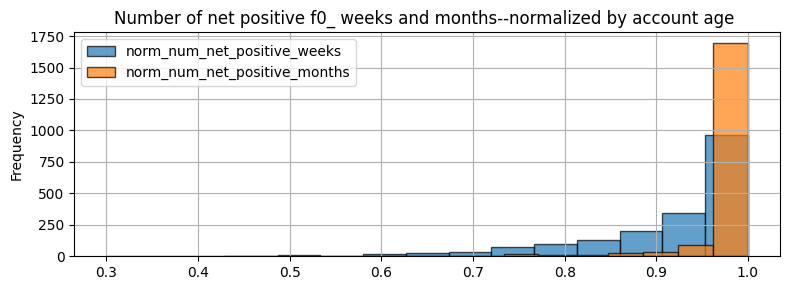

In [19]:
plt.figure(figsize=(8, 3))
plt.hist(features_for_ML['norm_num_net_positive_weeks'], bins=15, edgecolor='black', alpha=0.7)
plt.hist(features_for_ML['norm_num_net_positive_months'], bins=15, edgecolor='black', alpha=0.7)
plt.legend(['norm_num_net_positive_weeks','norm_num_net_positive_months'],loc='upper left')
plt.ylabel('Frequency')
#plt.xlim(-0.01,1.01)
#plt.ylim(0,1700)
plt.title('Number of net positive f0_ weeks and months--normalized by account age ')
plt.grid(True)
plt.tight_layout()
plt.show()

<div style="background-color: lightgreen; padding: 10px;">
*** Looks like there are more monthly net positive account. Are most account paid on a monthly basis?
    Or is this becuase of rent is paid monthly?
    - Need to compare to target variable. I just thought this was a little interesting
    
    Seems like the majority of account are net positive every month/week for at least 80% of the time..
</div>

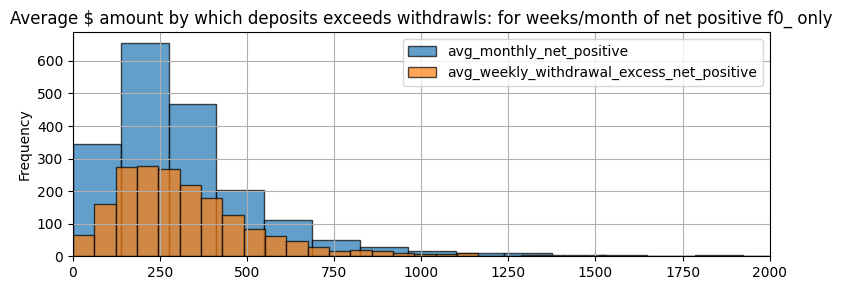

In [27]:
plt.figure(figsize=(8, 3))
plt.hist(features_for_ML['avg_monthly_net_positive'], bins=50, edgecolor='black', alpha=0.7)
plt.hist(features_for_ML['avg_weekly_net_positive'], bins=50, edgecolor='black', alpha=0.7)
plt.legend(['avg_monthly_net_positive','avg_weekly_withdrawal_excess_net_positive'],loc='upper right')
plt.ylabel('Frequency')
plt.xlim(0,2000)
#plt.ylim(0,400)
plt.title('Average $ amount by which deposits exceeds withdrawls: for weeks/month of net positive f0_ only')
plt.grid(True)
plt.tight_layout()
plt.show()

<div style="background-color: lightgreen; padding: 10px;">
*** Looks like more people have average monthly balance > average weekly balance
    need to verify this.. same pattern as above.
</div>

In [28]:
# Merge target variable : ***either 'paid_on_time' or 'paid_back'
#features_for_ML = features_for_ML.merge(cleaned_data_adv[['account_id', 'paid_back']], on='account_id', how='left')
features_for_ML = features_for_ML.merge(cleaned_data_adv[['account_id', 'paid_on_time']], on='account_id', how='left')
features_for_ML

,account_id,account_age_days,avg_f0_monthly,avg_f0_weekly,norm_num_net_positive_months,avg_monthly_net_positive,norm_num_net_positive_weeks,avg_weekly_net_positive,paid_on_time
0,00j9a14cpe87j,425,3.129400,1.452657,1.000000,313.269044,1.000000,329.279162,0
1,00q86t07z45h6,51,7.060446,17.130361,1.000000,532.418571,0.875000,482.041905,0
2,00wndxsnkr29c,424,-0.993212,-4.871179,0.933333,1089.617135,0.693548,1087.272667,0
3,00xk7rt4tjvem,413,3.531136,14.567898,1.000000,266.802753,0.927273,345.029376,1
4,01f4d9se2cztj,142,3.740626,-2.663537,1.000000,158.952031,0.923077,232.656403,1
...,...,...,...,...,...,...,...,...,...
1899,zwxfcb2hwez8t,410,-0.758873,15.058097,0.923077,253.205669,0.688889,421.171860,0
1900,zyr27262qxpbw,423,0.434130,0.497665,1.000000,349.846288,0.950820,365.617492,1
1901,zyrdzs6wdkbyp,426,-0.336318,1.715035,1.000000,97.430303,0.935484,105.834366,1
1902,zz51wn7r8r92m,410,0.990037,8.137085,0.928571,218.114052,0.843137,283.415173,0


<div style="background-color: lightgreen; padding: 10px;">
*** Now lets look at correlation with paying back loan on time. 
</div>

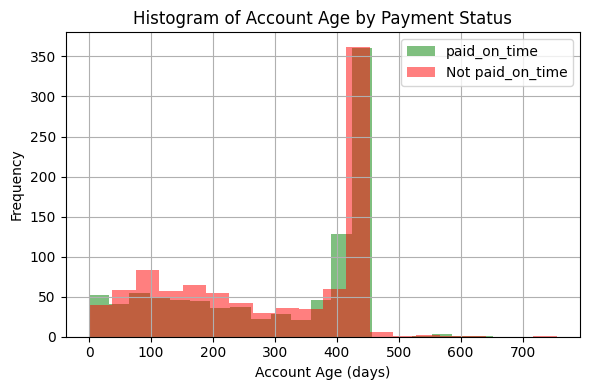

In [33]:
plt.figure(figsize=(6, 4))
plt.hist(features_for_ML['account_age_days'][features_for_ML['paid_on_time'] == 1], bins=20, alpha=0.5, color='green', label='paid_on_time')
plt.hist(features_for_ML['account_age_days'][features_for_ML['paid_on_time'] == 0], bins=20, alpha=0.5, color='red', label='Not paid_on_time')
plt.xlabel('Account Age (days)')
plt.ylabel('Frequency')
plt.title('Histogram of Account Age by Payment Status')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<div style="background-color: lightgreen; padding: 10px;">
*** Looks like theres no correlation so maybe dont include as a feature?
</div>

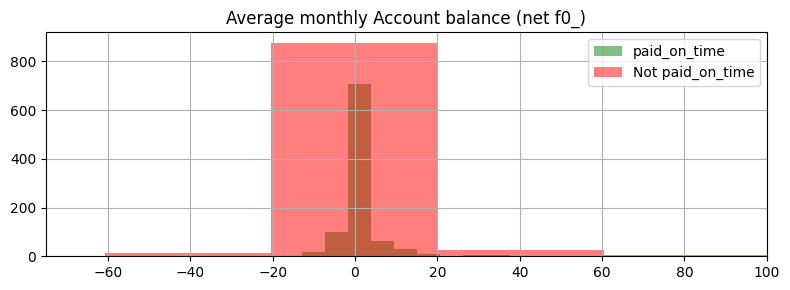

In [92]:
plt.figure(figsize=(8, 3))
plt.hist(features_for_ML['avg_f0_monthly'][features_for_ML['paid_on_time'] == 1], bins=100, alpha=0.5, color='green', label='paid_on_time')
plt.hist(features_for_ML['avg_f0_monthly'][features_for_ML['paid_on_time'] == 0], bins=100, alpha=0.5, color='red', label='Not paid_on_time')
plt.xlim(-75,100)
plt.title('Average monthly Account balance (net f0_)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<div style="background-color: lightgreen; padding: 10px;">
*** Hard to tell correlation. Need to plot seperatly?
</div>

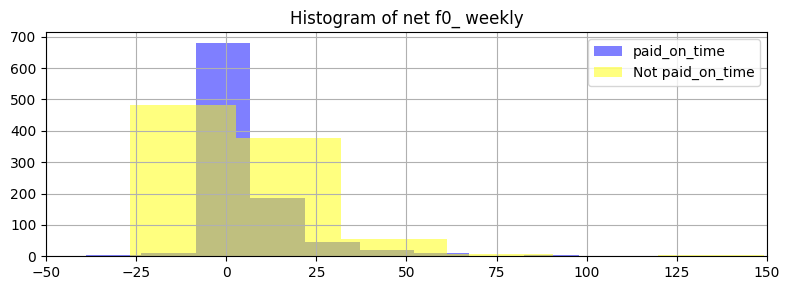

In [42]:
plt.figure(figsize=(8, 3))
plt.hist(features_for_ML['avg_f0_weekly'][features_for_ML['paid_on_time'] == 1], bins=40, alpha=0.5, color='blue', label='paid_on_time')
plt.hist(features_for_ML['avg_f0_weekly'][features_for_ML['paid_on_time'] == 0], bins=40, alpha=0.5, color='yellow', label='Not paid_on_time')
plt.xlim(-50,150)
plt.title('Histogram of net f0_ weekly')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<div style="background-color: lightgreen; padding: 10px;">
*** Looks like theres some correlation. More people paying on time also have more weeks/month with net f0_>0


ADD MORE PLOTS</div>

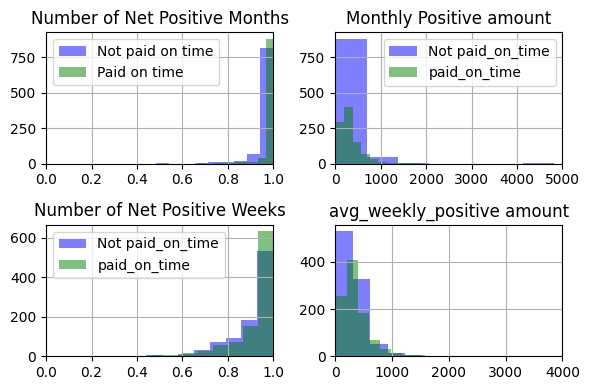

In [46]:
# Flotting Features
fig, axs = plt.subplots(2, 2, figsize=(6, 4))
# Histogram 1: Number of Net Positive Months
axs[0, 0].hist(features_for_ML['norm_num_net_positive_months'][features_for_ML['paid_on_time'] == 0], bins=10, alpha=0.5, color='blue', label='Not paid on time')
axs[0, 0].hist(features_for_ML['norm_num_net_positive_months'][features_for_ML['paid_on_time'] == 1], bins=10, alpha=0.5, color='green', label='Paid on time')
axs[0, 0].set_title('Number of Net Positive Months')
axs[0, 0].set_xlim(0, 1)  # Adjust the limits as per your data range
axs[0, 0].legend()
axs[0, 0].grid(True)
# Histogram 2: Average Monthly Positive
axs[0, 1].hist(features_for_ML['avg_monthly_net_positive'][features_for_ML['paid_on_time'] == 0], bins=10, alpha=0.5, color='blue', label='Not paid_on_time')
axs[0, 1].hist(features_for_ML['avg_monthly_net_positive'][features_for_ML['paid_on_time'] == 1], bins=10, alpha=0.5, color='green', label='paid_on_time')
axs[0, 1].set_title('Monthly Positive amount')
axs[0, 1].set_xlim(0, 5000)  # Adjust the limits as per your data range
axs[0, 1].legend()
axs[0, 1].grid(True)
# Histogram 3: Number of Net Positive Weeks
axs[1, 0].hist(features_for_ML['norm_num_net_positive_weeks'][features_for_ML['paid_on_time'] == 0], bins=10, alpha=0.5, color='blue', label='Not paid_on_time')
axs[1, 0].hist(features_for_ML['norm_num_net_positive_weeks'][features_for_ML['paid_on_time'] == 1], bins=10, alpha=0.5, color='green', label='paid_on_time')
axs[1, 0].set_xlim(0, 1)  
axs[1, 0].set_title('Number of Net Positive Weeks')
axs[1, 0].legend()
axs[1, 0].grid(True)
# Histogram 4: avg_weekly_positive
axs[1, 1].hist(features_for_ML['avg_weekly_net_positive'][features_for_ML['paid_on_time'] == 0], bins=10, alpha=0.5, color='blue', label='Not paid_on_time')
axs[1, 1].hist(features_for_ML['avg_weekly_net_positive'][features_for_ML['paid_on_time'] == 1], bins=10, alpha=0.5, color='green', label='paid_on_time')
axs[1, 1].set_title('avg_weekly_positive amount')
axs[1, 1].set_xlim(0, 4000)  
axs[1, 1].grid(True)
plt.tight_layout()
plt.show()

# <font color='purple'>Step 4. Selecting ML models</font>

In [84]:
feature_columns = [
    'account_age_days', # 1. Age of account
    'avg_f0_monthly', #2. Average monthly balance
    'avg_f0_weekly', #3. Average weekly balance
    'norm_num_net_positive_months', # 4. Number of months where deposits exceed witdrawls. Normalized
    'avg_monthly_net_positive', # 5. Monthly average amount by which withdrawals exceed deposits. Normalized
    'norm_num_net_positive_weeks', # 6. Number of weeks where deposits exceed witdrawls. Normalized
    'avg_weekly_net_positive' # 7. Weekly average amount by which withdrawals exceed deposits. Normalized
                    ]

In [85]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
X = features_for_ML[feature_columns]
y = features_for_ML['paid_on_time']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# <font color='red'>Logistic Regression:</font>

<div style="background-color: lightgreen; padding: 10px;">
*** Good for smaller dataset.. Works best when relationship between target and feature is linear. Not sure this is true in this case?
</div>

In [86]:
# Initialize the logistic regression model
logreg_model = LogisticRegression()
# Fit the model to the training data
logreg_model.fit(X_train, y_train)

/Users/isabellajohansson/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [87]:
# Make predictions on the test data
y_pred = logreg_model.predict(X_test)

# Evaluate the model
print("Logistic Regression Model Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Logistic Regression Model Evaluation:
Accuracy: 0.5249343832020997

Confusion Matrix:
 [[ 86  91]
 [ 90 114]]

Classification Report:
               precision    recall  f1-score   support

           0       0.49      0.49      0.49       177
           1       0.56      0.56      0.56       204

    accuracy                           0.52       381
   macro avg       0.52      0.52      0.52       381
weighted avg       0.52      0.52      0.52       381



<div style="background-color: lightgreen; padding: 10px;"> ** A accuracy of ~52% suggests that the model os only sligtly better than random guessing. I think this is just a weak model. Need more and better features. 
  
Look into regularization, L1 vs L2
</div>

# <font color='red'>Random Forest:</font>
<div style="background-color: lightgreen; padding: 10px;">
***  Can handle overfitting better than single decision trees, and can capture non-linear relationships.
</div>

In [88]:
from sklearn.ensemble import RandomForestClassifier

In [89]:
# Initialize the random forest model
rf_model = RandomForestClassifier(random_state=42)

# Fit the model to the training data
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [90]:
# Make predictions on the test data
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
print("Random Forest Model Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

Random Forest Model Evaluation:
Accuracy: 0.5380577427821522

Confusion Matrix:
 [[103  74]
 [102 102]]

Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.58      0.54       177
           1       0.58      0.50      0.54       204

    accuracy                           0.54       381
   macro avg       0.54      0.54      0.54       381
weighted avg       0.54      0.54      0.54       381



# <font color='red'>Gradient Boosting</font>
<div style="background-color: lightgreen; padding: 10px;">
*** Popular bc high predictive accuracy and ability to handle non-linear relationships</div>

In [91]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Assuming X_train, X_test, y_train, y_test are already defined

# Define and train the Gradient Boosting model
gradient_boosting_model = GradientBoostingClassifier()
gradient_boosting_model.fit(X_train, y_train)

# Make predictions
y_pred = gradient_boosting_model.predict(X_test)

# Classification Report with zero_division parameter
print("Classification Report gradient boosting model:")
print(classification_report(y_test, y_pred, zero_division=0))

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report gradient boosting model:
              precision    recall  f1-score   support

           0       0.50      0.51      0.50       177
           1       0.57      0.56      0.56       204

    accuracy                           0.54       381
   macro avg       0.53      0.53      0.53       381
weighted avg       0.54      0.54      0.54       381

Confusion Matrix:
[[ 90  87]
 [ 90 114]]


# Model Comparison:
<div style="background-color: lightgreen; padding: 10px;">
*** Need a better model first. I think mine is too weak to even compare for now.</div>



## 1. Accuracy:
- Logistic Regression: 
- Random Forest: 
- Gradient Boosting: 
## 2. Class 0 Metrics:
### Precision:
- Logistic Regression: 
- Random Forest: 
- Gradient Boosting: 
### Recall:
- Logistic Regression: 
- Random Forest: 
- Gradient Boosting: 
### F1 score:
- Logistic Regression: 
- Random Forest: 
- Gradient Boosting: 
## 3. Class 1 Metrics:
### Precision:
- Logistic Regression: 
- Random Forest: 
- Gradient Boosting: 
### Recall:
- Logistic Regression: 
- Random Forest: 
- Gradient Boosting: 
### F1 score:
- Logistic Regression: 
- Random Forest: 
- Gradient Boosting: 

<div style="background-color: lightblue; padding: 10px;">

<p>Here's how each metric applies in the context of loan qualification:</p>

<h4>Precision</h4>
<p>Precision measures the accuracy of the positive predictions (i.e., accounts predicted to be eligible for a loan).</p>

$$ Precision = \frac{True Positives}{True Positives + False Positives}
$$

<ul>
  <li><strong>High Precision:</strong> When the model predicts an account is eligible for a loan, it is often correct.</li>
  <li><strong>Low Precision:</strong> The model frequently predicts eligibility incorrectly.</li>
</ul>

If precision is high, it means most of the accounts that the model classifies as loan-eligible are indeed eligible, leading to fewer unnecessary approvals.</p>

<h4>Recall</h4>
<p>Recall (also known as Sensitivity or True Positive Rate) measures how well the model identifies all the actual positive cases.</p>

$$
Recall = \frac{True Positives}{True Positives + False Negatives}
$$

<ul>
  <li><strong>High Recall:</strong> The model identifies most of the actual loan-eligible accounts.</li>
  <li><strong>Low Recall:</strong> The model misses many loan-eligible accounts.</li>
</ul>

<p><strong>Example:</strong><br>
If recall is high, it means the model catches most of the accounts that should be approved for loans, ensuring that eligible customers are not overlooked.</p>

<h4>F1-Score</h4>
<p>The F1-score is the harmonic mean of precision and recall, providing a balance between the two metrics.</p>

$$F1-score = 2 \times \frac{Precision \times Recall}{Precision + Recall}$$

<ul>
  <li><strong>High F1-Score:</strong> Both precision and recall are reasonably high.</li>
  <li><strong>Low F1-Score:</strong> Either precision or recall (or both) are low.</li>
</ul>

<p><strong>Example:</strong><br>
A high F1-score means the model is good at both identifying loan-eligible accounts and not misclassifying ineligible accounts as eligible, providing a balanced performance.</p>

<h3>Practical Implications in Loan Qualification:</h3>

<p><strong>Precision in Loan Qualification:</strong> High precision ensures that when the model predicts an account is loan-eligible, it is likely to be correct, reducing the risk of loan defaults by minimizing false positives.</p>

<p><strong>Recall in Loan Qualification:</strong> High recall ensures that the model identifies most of the actual loan-eligible accounts, reducing the risk of missing potential customers who are eligible for loans.</p>
</div>